In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import pickle
import glob

import json
import pandas
from collections import Counter

from matplotlib import colors
divnorm = colors.TwoSlopeNorm(vmin=-0.7, vcenter=0, vmax=0.7)
divnorm_prob = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

figpath = os.path.join("fig")
fitspath = os.path.join("modelfits")
data_savepath = os.path.join("data")
dataset_name = "exp2"

# Stimuli

In [2]:
nu = 0.1
logistic_growth = lambda t, theta: theta[:,0] + theta[:,1]/(1+np.exp(-theta[:,2]*(3*t-theta[:,3])))

def log_normpdf(x, mean, std):
    log_normpdf_unnorm = -np.log(std)-0.5*np.log(2*np.pi)-0.5*((x-mean)/std)**2
    return log_normpdf_unnorm

def traj_r_T_estimation(rs_traj, t_now=2, T_end=10, dt=1, thetas_support=None, nu=nu, thetas_traj=None, is_plot=False):
    '''Assume that ts is a vector from t=0 to t=t_now, with spacing of 1 unit. 
       Hence, the length of rs_traj should be at least t_now.
       Also, T_end must be larger than t_now.
    '''
    if(t_now<0): # Prior; no evidence r observed so far.
        ts_train = []
    else:
        ts_train = np.arange(0,t_now,dt)[:,None]
    (num_thetas, thetas_dim) = thetas_support.shape
    
    
    # Grid of integration. Needs to be more finer. 
    r_T_grid = np.linspace(-3,5,400)
    
    # 1) Find p(theta|r) as a function of theta.
    log_p_thetaj_given_rj = np.zeros((num_thetas))
    for theta_val_idx in range(num_thetas):
            # Current theta value
            theta_val = thetas_support[theta_val_idx][None,:]
            # Instantiate the flat prior p(theta). 
            log_p_thetaj_given_rj[theta_val_idx] = -np.log(num_thetas)
            for t0_idx in range(len(ts_train)):
                t0 = ts_train[t0_idx]
                r_t0_traj = rs_traj[t0_idx]
                rho_t_given_thetaj = logistic_growth(t0, theta_val)
                log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)
    log_p_thetaj_given_rj_normalized =  log_p_thetaj_given_rj - scipy.special.logsumexp(log_p_thetaj_given_rj)    

    # 2) Find p(r_T | rho(T; theta))
    log_r_T_given_thetaj = np.zeros((len(r_T_grid), num_thetas))
    for theta_val_idx in range(num_thetas):
        # Current theta value
        theta_val = thetas_support[theta_val_idx][None,:]
        rho_T_given_thetaj = logistic_growth(T_end, theta_val)
        log_r_T_given_thetaj[:, theta_val_idx] = log_normpdf(r_T_grid, rho_T_given_thetaj, nu)

    # 3) Find p(r_T | r)
    log_p_r_T_and_theta_given_r = log_r_T_given_thetaj + log_p_thetaj_given_rj_normalized[None,:]
    p_r_T_given_r = np.sum(np.exp(log_p_r_T_and_theta_given_r), axis=-1) # Integrate over possible theta values
    p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
    post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)
    post_mode = r_T_grid[np.argmax(p_r_T_given_r)]  
    
    
    # Sanity check:
    if(is_plot):
        print("Posterior mean for r_T: ",  post_mean)
        print("Posterior mode for r_T: ",  post_mode)
        
        sorted_array = -np.sort(-log_p_thetaj_given_rj_normalized.reshape(-1))
        print("theta_true:", thetas_traj)
        
        fig, ax = plt.subplots(1,2,figsize=(8,4))
        ax[0].plot(ts, logistic_growth(ts, thetas_traj[None,:]), "k-", label="true traj")
        ax[0].plot(np.squeeze(ts[ts_train]), np.squeeze(rs_traj[ts_train]), "r.", label="training data")
        theta_postmean = np.sum(np.exp(log_p_thetaj_given_rj_normalized)[:,None]*thetas_support, axis=0)[None,:]
        ax[0].plot(ts, logistic_growth(np.squeeze(ts), theta_postmean), "C0--", label="rho(t; E[theta|r])")
        for traj_idx in range(1):
            theta_map_idx = np.where(log_p_thetaj_given_rj_normalized == sorted_array[traj_idx])
            theta_map = thetas_support[theta_map_idx]
            print("theta_map: ",np.squeeze(theta_map))
            ax[0].plot(ts, logistic_growth(np.squeeze(ts), theta_map), "C1--", label="rho(t; Mode[theta|r])")
        ax[0].plot(ts, trajs, "k-", alpha=0.1)
        ax[0].set_ylim([0,1])
        ax[0].set_ylabel("Performance")
        ax[0].set_xlabel("Time")
        ax[0].legend()
        
        ax[1].plot(p_r_T_given_r, r_T_grid, "k-", label="p(r_T | r)")
        ax[1].plot([0,5],[rs_traj[T_end], rs_traj[T_end]], "k--", label="true r_T")
        ax[1].plot([0,5],[post_mean, post_mean], "C0--", label="E[r_T|r]")
        ax[1].plot([0,5],[post_mode, post_mode], "C1--", label="Mode[r_T|r]")
        ax[1].set_ylabel("r_T")
        ax[1].set_xlabel("p(r_T | r)")
        ax[1].set_ylim([0,1])
        ax[1].legend()
        
        plt.suptitle("theta_true="+str(np.round(thetas_traj,2))+", t_now="+str(t_now)+", T_end="+str(T_end))
        plt.tight_layout()
    
    if(is_plot):
        return post_mean, post_mode, fig
    else:
        return post_mean, post_mode


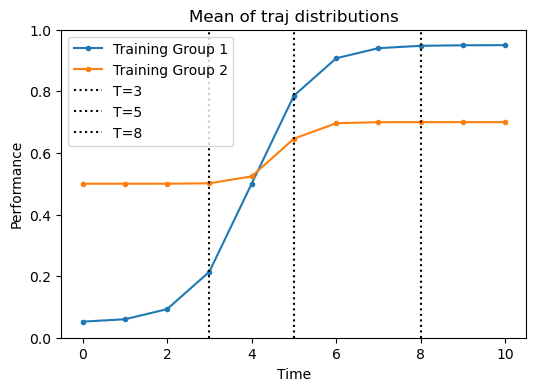

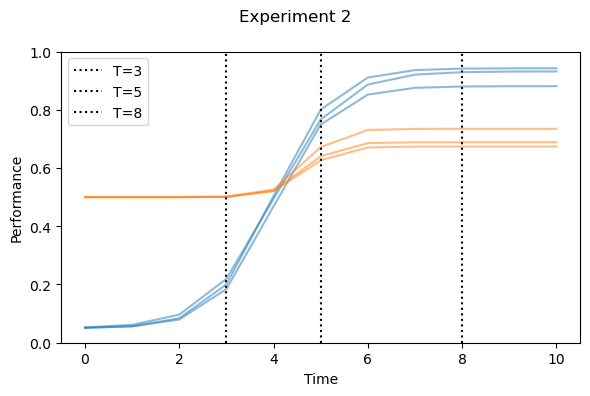

2

In [3]:
# Experiment 2A questions

dt=1
ts = np.arange(0,11,dt)[:,None]
t_nows = [2,2,2]
T_ends = [3,5,8]
colors = ["C0","C1"]
agent_names = ["velocity", "exploitation"]

# 1) The means of trajs
theta0 = np.array([[0.05,0.9,0.5,12]]) # theta[2]=0.8
theta1 = np.array([[0.5,0.2,1,14]])
theta_sigmas = np.array([0,0.03,0.03,0.03])

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(logistic_growth(ts, theta0),"C0.-", label="Training Group 1")
plt.plot(logistic_growth(ts, theta1),"C1.-", label="Training Group 2")
for T_end in T_ends:
    plt.plot([T_end,T_end], [0,1.4], "k:", label="T="+str(T_end))
ax.set_xlabel("Time")
ax.set_ylabel("Performance")
ax.set_ylim([0,1])
ax.set_title("Mean of traj distributions")
plt.legend()
plt.show()

# 2) Actual data
num_thetas = 3
theta_dims = theta0.shape[1]
np.random.seed(1)
thetas_0 = np.random.normal(loc=theta0, scale=theta_sigmas, size=(num_thetas,theta_dims))
thetas_1 = np.random.normal(loc=theta1, scale=theta_sigmas, size=(num_thetas,theta_dims))
trajs_0 = logistic_growth(ts, thetas_0)
trajs_1 = logistic_growth(ts, thetas_1)
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(trajs_0,"C0-", alpha=0.5)
plt.plot(trajs_1,"C1-", alpha=0.5)
for T_end in T_ends:
    plt.plot([T_end,T_end], [0,1.4], "k:", label="T="+str(T_end))
ax.set_xlabel("Time")
ax.set_ylabel("Performance")
ax.set_ylim([0,1])
plt.legend()
plt.suptitle("Experiment 2")

plt.tight_layout()
#plt.savefig(os.path.join(figpath,"example_trajs_exp2"), dpi=300)
plt.show()

Thetas = {agent_names[0]: thetas_0, agent_names[1]: thetas_1}
Trajs = {agent_names[0]: trajs_0, agent_names[1]: trajs_1}
len(Trajs)

# Human data

C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\600107500.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choices = np.zeros((int(n_subjs[start_agent]),n_questions))
C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\600107500.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choices = np.zeros((int(n_subjs[start_agent]),n_questions))


                    0
F                  55
M                  43
Non-binary          1
Prefer not to say   1

                    0
F                  48
M                  50
Prefer not to say   2

[[0.27 0.67 0.83]
 [0.83 0.62 0.1 ]]


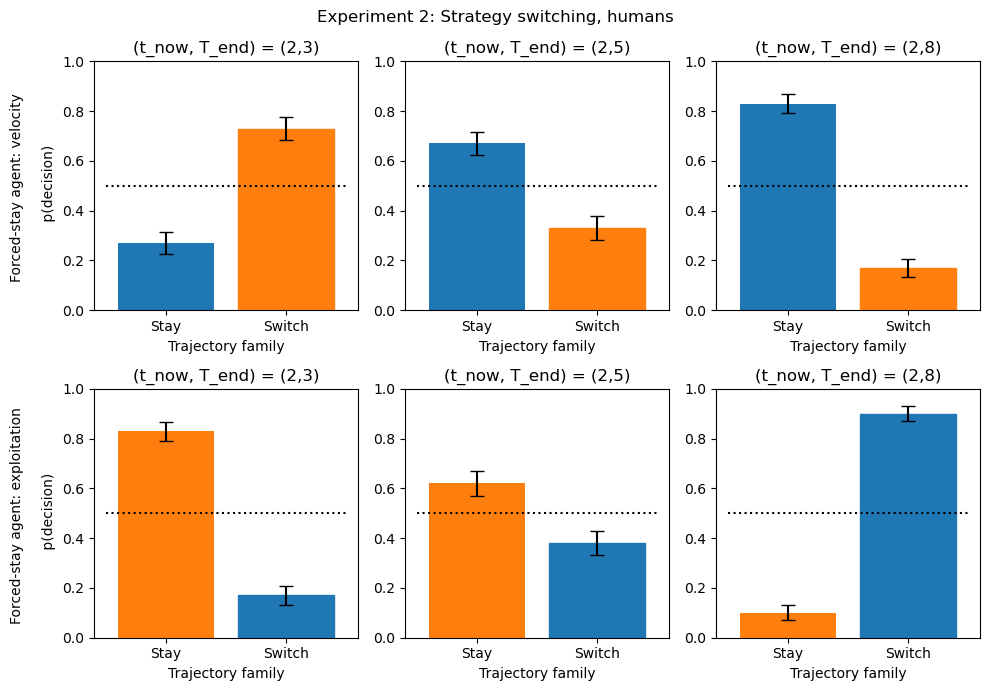

In [4]:
filename = os.path.join(data_savepath,"exp2_data_df.csv")
exp2_data_df = pd.read_csv(filename)
n_questions = len(T_ends)
n_subjs = np.zeros((2,1))
choices_mean = np.zeros((2, n_questions))
choices_std = np.zeros((2, n_questions))
choices_sem = np.zeros((2, n_questions))
choices_allconds = {}
testtrajidx_allconds = {}
genders_allconds = {}
ages_allconds = {}
comments_allconds = {}

fig,ax = plt.subplots(2,3, figsize=(10,7))

for start_agent in range(2):
    exp2_data_df_cond = exp2_data_df[exp2_data_df["startAgent"]==agent_names[start_agent].lower()]
    n_subjs[start_agent] = len(np.unique(exp2_data_df_cond["SubjectID"]))
    choices = np.zeros((int(n_subjs[start_agent]),n_questions))
    for question in range(n_questions):
        choices[:,question] = exp2_data_df_cond[exp2_data_df_cond["T_end"]==T_ends[question]]["chooseSwitch"].to_numpy()

    testtrajidxs = exp2_data_df_cond[exp2_data_df_cond["T_end"]==3]["testTrajIdx"]
    testtrajidx_allconds[agent_names[start_agent]] = testtrajidxs.to_numpy().astype(int);
    choices_allconds[agent_names[start_agent]] = 1-choices # Originnaly in choices, Stay is 0, Switch is 1. Need to flip this.
    choices_mean[start_agent,:] = 1-np.mean(choices, axis=0) # Originnaly in choices, Stay is 0, Switch is 1. Need to flip this.
    choices_std[start_agent,:] = np.std(1-choices, ddof=1, axis=0) #ddof = 1 means computing the sample std with (N-1) as denom
    choices_sem[start_agent,:] = choices_std[start_agent,:]/np.sqrt(n_subjs[start_agent])
    
    # Demographics
    ages = exp2_data_df_cond[exp2_data_df_cond["T_end"]==3]["Age"].to_numpy()
    genders = exp2_data_df_cond[exp2_data_df_cond["T_end"]==3]["Gender"].to_numpy()
    comments = exp2_data_df_cond[exp2_data_df_cond["T_end"]==3]["Comments"].to_numpy()
    letter_counts = Counter(genders)
    df_gender = pandas.DataFrame.from_dict(letter_counts, orient='index')
    ages_allconds[agent_names[start_agent]] = ages
    genders_allconds[agent_names[start_agent]] = genders
    comments_allconds[agent_names[start_agent]] = comments
    letter_counts = Counter(genders)
    df_gender = pandas.DataFrame.from_dict(letter_counts, orient='index')
    print(df_gender)
    print()
    
    # Experiment 2, human choice probs visualization
    for T_end_idx in range(len(T_ends)):
        t_now = t_nows[T_end_idx]
        T_end = T_ends[T_end_idx]
        bar=ax[start_agent,T_end_idx].bar([0,1],[choices_mean[start_agent,T_end_idx], 1-choices_mean[start_agent,T_end_idx]], color=colors[start_agent])
        bar[1].set_color(colors[1-start_agent])

        ax[start_agent,T_end_idx].errorbar([0,1],[choices_mean[start_agent,T_end_idx], 1-choices_mean[start_agent,T_end_idx]], yerr=[choices_sem[start_agent,T_end_idx],choices_sem[start_agent,T_end_idx]], color="k", linestyle="", capsize=5)

        ax[start_agent, T_end_idx].plot([-0.5,1.5],[0.5,0.5], "k:")
        ax[start_agent, 0].set_ylabel("Forced-stay agent: "+agent_names[start_agent]+" \n \n p(decision)")
        ax[start_agent, T_end_idx].set_ylim([0,1])
        ax[start_agent, T_end_idx].set_xticks([0,1], labels=["Stay","Switch"])
        ax[start_agent, T_end_idx].set_xlabel("Trajectory family")
        ax[start_agent, T_end_idx].set_title("(t_now, T_end) = ({0},{1})".format(t_now,T_end))
    
print(choices_mean)
plt.suptitle("Experiment 2: Strategy switching, humans")
plt.tight_layout()
#plt.savefig(os.path.join(figpath,dataset_name+"_switch_humanprobs"), dpi=300)
plt.show()

In [5]:
# Save data and trajectories
a = {"mturk_IDs":[], "Thetas": Thetas, "Trajs": Trajs, "theta_sigmas": theta_sigmas, "t_nows":t_nows, "T_ends":T_ends, "ts": ts, "testtrajidx_allconds":testtrajidx_allconds, "choices_allconds": choices_allconds, "ages_allconds":ages_allconds, "genders_allconds":genders_allconds,"comments_allconds":comments_allconds}
with open(os.path.join(data_savepath,'exp2_data.pickle'), 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(data_savepath,'exp2_data.pickle'), 'rb') as handle:
    b = pickle.load(handle)

# Model fits

In [6]:
nu = 0.1
logistic_growth = lambda t, theta: theta[:,0] + theta[:,1]/(1+np.exp(-theta[:,2]*(3*t-theta[:,3])))

def log_normpdf(x, mean, std):
    log_normpdf_unnorm = -np.log(std)-0.5*np.log(2*np.pi)-0.5*((x-mean)/std)**2
    return log_normpdf_unnorm

def traj_r_T_estimation(rs_traj, t_now=2, T_end=10, dt=1, thetas_support=None, nu=nu, thetas_traj=None, is_plot=False):
    '''Assume that ts is a vector from t=0 to t=t_now, with spacing of 1 unit. 
       Hence, the length of rs_traj should be at least t_now.
       Also, T_end must be larger than t_now.
    '''
    if(t_now<0): # Prior; no evidence r observed so far.
        ts_train = []
    else:
        ts_train = np.arange(0,t_now,dt)[:,None]
    (num_thetas, thetas_dim) = thetas_support.shape
    
    
    # Grid of integration. Needs to be more finer. 
    r_T_grid = np.linspace(-3,5,400)
    
    # 1) Find p(theta|r) as a function of theta.
    log_p_thetaj_given_rj = np.zeros((num_thetas))
    for theta_val_idx in range(num_thetas):
            # Current theta value
            theta_val = thetas_support[theta_val_idx][None,:]
            # Instantiate the flat prior p(theta). 
            log_p_thetaj_given_rj[theta_val_idx] = -np.log(num_thetas)
            for t0_idx in range(len(ts_train)):
                t0 = ts_train[t0_idx]
                r_t0_traj = rs_traj[t0_idx]
                rho_t_given_thetaj = logistic_growth(t0, theta_val)
                log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)
    log_p_thetaj_given_rj_normalized =  log_p_thetaj_given_rj - scipy.special.logsumexp(log_p_thetaj_given_rj)    

    # 2) Find p(r_T | rho(T; theta))
    log_r_T_given_thetaj = np.zeros((len(r_T_grid), num_thetas))
    for theta_val_idx in range(num_thetas):
        # Current theta value
        theta_val = thetas_support[theta_val_idx][None,:]
        rho_T_given_thetaj = logistic_growth(T_end, theta_val)
        log_r_T_given_thetaj[:, theta_val_idx] = log_normpdf(r_T_grid, rho_T_given_thetaj, nu)

    # 3) Find p(r_T | r)
    log_p_r_T_and_theta_given_r = log_r_T_given_thetaj + log_p_thetaj_given_rj_normalized[None,:]
    p_r_T_given_r = np.sum(np.exp(log_p_r_T_and_theta_given_r), axis=-1) # Integrate over possible theta values
    p_r_T_given_r = p_r_T_given_r/np.trapz(p_r_T_given_r, x=r_T_grid)
    post_mean = np.trapz(r_T_grid*p_r_T_given_r, x=r_T_grid)
    post_mode = r_T_grid[np.argmax(p_r_T_given_r)]  
    
    
    # Sanity check:
    if(is_plot):
        print("Posterior mean for r_T: ",  post_mean)
        print("Posterior mode for r_T: ",  post_mode)
        
        sorted_array = -np.sort(-log_p_thetaj_given_rj_normalized.reshape(-1))
        print("theta_true:", thetas_traj)
        
        fig, ax = plt.subplots(1,2,figsize=(8,4))
        ax[0].plot(ts, logistic_growth(ts, thetas_traj[None,:]), "k-", label="true traj")
        ax[0].plot(np.squeeze(ts[ts_train]), np.squeeze(rs_traj[ts_train]), "r.", label="training data")
        theta_postmean = np.sum(np.exp(log_p_thetaj_given_rj_normalized)[:,None]*thetas_support, axis=0)[None,:]
        ax[0].plot(ts, logistic_growth(np.squeeze(ts), theta_postmean), "C0--", label="rho(t; E[theta|r])")
        for traj_idx in range(1):
            theta_map_idx = np.where(log_p_thetaj_given_rj_normalized == sorted_array[traj_idx])
            theta_map = thetas_support[theta_map_idx]
            print("theta_map: ",np.squeeze(theta_map))
            ax[0].plot(ts, logistic_growth(np.squeeze(ts), theta_map), "C1--", label="rho(t; Mode[theta|r])")
        ax[0].plot(ts, trajs, "k-", alpha=0.1)
        ax[0].set_ylim([0,1])
        ax[0].set_ylabel("Performance")
        ax[0].set_xlabel("Time")
        ax[0].legend()
        
        ax[1].plot(p_r_T_given_r, r_T_grid, "k-", label="p(r_T | r)")
        ax[1].plot([0,5],[rs_traj[T_end], rs_traj[T_end]], "k--", label="true r_T")
        ax[1].plot([0,5],[post_mean, post_mean], "C0--", label="E[r_T|r]")
        ax[1].plot([0,5],[post_mode, post_mode], "C1--", label="Mode[r_T|r]")
        ax[1].set_ylabel("r_T")
        ax[1].set_xlabel("p(r_T | r)")
        ax[1].set_ylim([0,1])
        ax[1].legend()
        
        plt.suptitle("theta_true="+str(np.round(thetas_traj,2))+", t_now="+str(t_now)+", T_end="+str(T_end))
        plt.tight_layout()
    
    if(is_plot):
        return post_mean, post_mode, fig
    else:
        return post_mean, post_mode


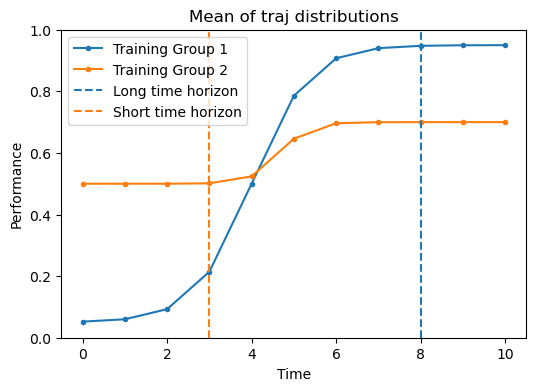

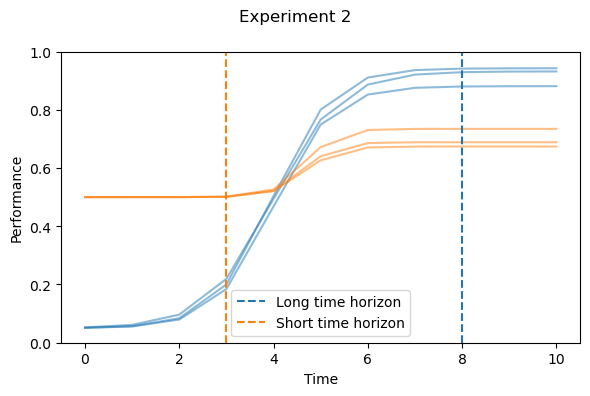

2

In [7]:
# Experiment 2A questions

dt=1
ts = np.arange(0,11,dt)[:,None]

# 1) The means of trajs
theta0 = np.array([[0.05,0.9,0.5,12]]) # theta[2]=0.8
theta1 = np.array([[0.5,0.2,1,14]])

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(logistic_growth(ts, theta0),"C0.-", label="Training Group 1")
plt.plot(logistic_growth(ts, theta1),"C1.-", label="Training Group 2")
plt.plot([8,8], [0,1.4], "C0--", label="Long time horizon")
plt.plot([3,3], [0,1.4], "C1--", label="Short time horizon")
ax.set_xlabel("Time")
ax.set_ylabel("Performance")
ax.set_ylim([0,1])
ax.set_title("Mean of traj distributions")
plt.legend()
plt.show()

# 2) Actual data
num_thetas = 3
theta_dims = theta0.shape[1]
np.random.seed(1)
thetas_0 = np.random.normal(loc=theta0, scale=[0,0.03,0.03,0.03], size=(num_thetas,theta_dims))
thetas_1 = np.random.normal(loc=theta1, scale=[0,0.03,0.03,0.03], size=(num_thetas,theta_dims))
trajs_0 = logistic_growth(ts, thetas_0)
trajs_1 = logistic_growth(ts, thetas_1)
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(trajs_0,"C0-", alpha=0.5)
plt.plot(trajs_1,"C1-", alpha=0.5)
plt.plot([8,8], [0,1.4], "C0--", label="Long time horizon")
plt.plot([3,3], [0,1.4], "C1--", label="Short time horizon")
ax.set_xlabel("Time")
ax.set_ylabel("Performance")
ax.set_ylim([0,1])
plt.legend()
plt.suptitle("Experiment 2")

plt.tight_layout()
plt.savefig(os.path.join(figpath,"example_trajs_exp2"), dpi=300)
plt.show()

Thetas = {agent_names[0]: thetas_0, agent_names[1]: thetas_1}
Trajs = {agent_names[0]: trajs_0, agent_names[1]: trajs_1}
len(Trajs)

## Logistic model

In [8]:
p_stay_logistic = lambda diff, slope, offset: 1 / (1 + np.exp(offset - slope * diff))

def prob_stay_logistic(theta=[0.1,10,0], T_end=T_end, start_agent="velocity", model="bayesian_postmean", include_offset_param=True, Thetas=Thetas, Trajs=Trajs, rs_traj=[], t_now=-1, dt=dt, is_plot=False):
    nu = theta[0]
    slope = theta[1]
    if(include_offset_param):
        offset = theta[2]
    else:
        offset = 0

    if(model=="bayesian_postmean"):
        if(start_agent=="velocity"):
            velocity_final_height, _ = traj_r_T_estimation(rs_traj=rs_traj, t_now=t_now, T_end=T_end, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)
            exploitation_final_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=T_end-t_now, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)            
            final_height_diff = velocity_final_height - exploitation_final_height
        else:
            exploitation_final_height, _ = traj_r_T_estimation(rs_traj=rs_traj, t_now=t_now, T_end=T_end, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)       
            velocity_final_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=T_end-t_now, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)
            final_height_diff = exploitation_final_height - velocity_final_height
        prob_stay = p_stay_logistic(final_height_diff, slope, offset)
        
    elif(model=="velocity"):
        if(start_agent=="velocity"):
            velocity_final_height, _ = traj_r_T_estimation(rs_traj=rs_traj, t_now=t_now, T_end=T_end, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)
            exploitation_final_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=T_end-t_now, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)    
            velocity_current_height, _ = traj_r_T_estimation(rs_traj=rs_traj, t_now=t_now, T_end=t_now, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)
            exploitation_current_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=0, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)            
            velocity_traj0_Tend = (velocity_final_height-velocity_current_height)/(T_end-t_now)
            velocity_traj1_Tend = (exploitation_final_height-exploitation_current_height)/(T_end-t_now)
            velocity_diff = velocity_traj0_Tend - velocity_traj1_Tend
        else:
            exploitation_final_height, _ = traj_r_T_estimation(rs_traj=rs_traj, t_now=t_now, T_end=T_end, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)
            velocity_final_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=T_end-t_now, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)    
            exploitation_current_height, _ = traj_r_T_estimation(rs_traj=rs_traj, t_now=t_now, T_end=t_now, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)
            velocity_current_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=0, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)            
            velocity_traj0_Tend = (velocity_final_height-velocity_current_height)/(T_end-t_now)
            velocity_traj1_Tend = (exploitation_final_height-exploitation_current_height)/(T_end-t_now)
            velocity_diff = velocity_traj1_Tend - velocity_traj0_Tend
        #softmax_velocity_Tend = np.exp(beta*velocity_traj0_Tend)/(np.exp(beta*velocity_traj0_Tend)+np.exp(beta*velocity_traj1_Tend))
        prob_stay = p_stay_logistic(velocity_diff, slope, offset)
        
    elif(model=="exploitation_heuristic"):
        # Myopic model, like MVT. Compares current heights of starting and new trajectory.
        if(start_agent=="velocity"):
            exploitation_initial_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=0, dt=dt, nu=nu, thetas_support=Thetas["exploitation"], is_plot=is_plot)            
            current_height_diff = rs_traj[t_now] - exploitation_initial_height
        else:
            velocity_initial_height, _ = traj_r_T_estimation(rs_traj=[], t_now=-1, T_end=0, dt=dt, nu=nu, thetas_support=Thetas["velocity"], is_plot=is_plot)            
            current_height_diff = rs_traj[t_now] - velocity_initial_height
        prob_stay = p_stay_logistic(current_height_diff, slope, offset)
        
    elif(model=="velocity_heuristic"):
        # Compares the average velocity of the starting trajectory so far, to its most recent velocity. More likely to switch if the latter is smaller than former.
        velocity_diff = (rs_traj[t_now]- rs_traj[t_now-1]) - (rs_traj[t_now]-rs_traj[0])/(t_now)
        prob_stay = p_stay_logistic(velocity_diff, slope, offset)
        

    return prob_stay


prob_stay_logistic(theta=[0.1,10,0], T_end=3, t_now=2, rs_traj = Trajs["velocity"][0], start_agent="velocity", model="bayesian_postmean")

C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\2668785260.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)


0.04801724896740954

In [9]:
num_testtrajs = Trajs[agent_names[0]].shape[1]
num_subjss = np.zeros((len(agent_names),num_testtrajs, n_questions))
num_choosestays = np.zeros((len(agent_names),num_testtrajs, n_questions))

for start_agent_idx in range(len(agent_names)):
    agent_name = agent_names[start_agent_idx]
    choices_cond = choices_allconds[agent_name]
    testtrajidx_cond = testtrajidx_allconds[agent_name]
    for testtraj_idx in range(num_testtrajs):
        relevant_subjs = np.where(testtrajidx_cond==testtraj_idx)[0]
        num_subjss[start_agent_idx, testtraj_idx,:] = len(relevant_subjs)
        num_choosestays[start_agent_idx, testtraj_idx,:] = np.sum(choices_cond[relevant_subjs,:], axis=0)
print(num_subjss)
print()
print(num_choosestays/num_subjss)

def crossentropy_loss(theta, T_ends=[3,5,8], t_nows=[2,2,2], start_agents=["velocity","exploitation"], model="bayesian_postmean", num_choosestays=num_choosestays, num_subjss=num_subjss, include_offset_param=True):
    loss = 0;
    for start_agent_idx in range(len(start_agents)):
        trajs = Trajs[start_agents[start_agent_idx]]
        num_testtrajs = trajs.shape[1]
        for testtraj_idx in range(num_testtrajs):
            rs_traj = trajs[:,testtraj_idx]
            for T_end_idx in range(len(T_ends)):
                n_subj = num_subjss[start_agent_idx,testtraj_idx,T_end_idx]
                if(n_subj==0):
                    continue
                n_choosestay = num_choosestays[start_agent_idx,testtraj_idx,T_end_idx]
                model_prob_pred = prob_stay_logistic(theta=theta, start_agent=start_agents[start_agent_idx], T_end=T_ends[T_end_idx], t_now=t_nows[T_end_idx], model=model, rs_traj=rs_traj, include_offset_param=include_offset_param)
                # The idea here is doing cross-entropy loss over each participant's response, and then summing them up.
                loss = loss + (-np.log(model_prob_pred)*n_choosestay - np.log(1-model_prob_pred)*(n_subj-n_choosestay))
    return loss
        

[[[38. 38. 38.]
  [26. 26. 26.]
  [36. 36. 36.]]

 [[29. 29. 29.]
  [31. 31. 31.]
  [40. 40. 40.]]]

[[[0.21052632 0.73684211 0.86842105]
  [0.30769231 0.76923077 0.96153846]
  [0.30555556 0.52777778 0.69444444]]

 [[0.82758621 0.65517241 0.17241379]
  [0.90322581 0.70967742 0.09677419]
  [0.775      0.525      0.05      ]]]


In [11]:

# T_ends = [3,5,8]
# t_nows = [2,2,2]
start_agents=agent_names
models = ["bayesian_postmean","velocity","exploitation_heuristic","velocity_heuristic"]
n_inits = 10


for include_offset_param in [True,False]:

    if(include_offset_param):
        lb = [1e-3, 1e-3, -10]
        ub = [1.5, 50, 10]
        suffix_offset = "_offset"
    else:
        lb = [1e-3, 1e-3]
        ub = [1.5, 50]
        suffix_offset = "_nooffset"


    params_init = np.zeros((len(models), n_inits, len(lb)))
    params_fitted = np.zeros((len(models), n_inits, len(lb)))
    crossentropy_fitted = np.zeros((len(models), n_inits))
    constraint = scipy.optimize.Bounds(lb=lb, ub=ub)
    for model_idx in range(len(models)):
        model = models[model_idx]
        print(model, include_offset_param)
        for rand_init_idx in range(n_inits):
            print(rand_init_idx)
            params_init[model_idx, rand_init_idx,:] = np.random.uniform(low=lb, high=ub)
            res = scipy.optimize.minimize(crossentropy_loss, np.squeeze(params_init[model_idx, rand_init_idx,:]), bounds=constraint, 
                                      args = (T_ends, t_nows, start_agents, model, num_choosestays, num_subjss, include_offset_param), method='L-BFGS-B', options={'disp': True})
            params_fitted[model_idx,:] = res.x
            crossentropy_fitted[model_idx] = res.fun

    bestfit_idx_bymodel = np.argmin(crossentropy_fitted, axis=1)
    params_fitted_best = np.zeros((len(models), len(lb)))
    for model_idx in range(len(models)):
        params_fitted_best[model_idx,:] = params_fitted[model_idx,bestfit_idx_bymodel[model_idx],:]
    print(np.round(params_fitted_best,2))
    print(np.min(crossentropy_fitted,axis=1))


    import pickle
    filename = dataset_name+"_fits_logistic_heuristics"+suffix_offset
    a = {'params_init':params_init,'params_fitted':params_fitted, 'best_params_fitted':params_fitted_best, 'crossentropy_fitted':crossentropy_fitted, 'models':models, 'include_offset_param':include_offset_param, 'mturk_IDs': [], 'data_dims': ["start_agent", "subject","question (T_end = 3,5,8 in this order)"], 'data': choices_allconds}
    with open(os.path.join(fitspath,filename+'.pickle'), 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)


bayesian_postmean True
0


C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\2668785260.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)


1
2
3
4
5
6
7
8
9
velocity True
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True
0
1
2
3
4
5
6
7
8
9
[[ 1.500e+00  4.040e+00  3.300e-01]
 [ 1.500e+00  4.750e+00  2.000e-02]
 [ 1.150e+00  0.000e+00 -2.100e-01]
 [ 1.020e+00  2.429e+01 -8.000e-02]]
[340.22574447 397.37769394 412.4778638  411.00962041]
bayesian_postmean False
0
1
2
3
4
5
6
7
8
9
velocity False
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic False
0
1
2
3
4
5
6
7
8
9
velocity_heuristic False
0
1
2
3
4
5
6
7
8
9
[[ 0.57  3.24]
 [ 1.5   4.68]
 [ 0.49  0.  ]
 [ 1.2  30.91]]
[345.59586828 397.39673024 415.89722602 411.23179651]


### Visualization

C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\380331300.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax[forced_agent,subplot_count].errorbar(range(num_tasks),choices_mean[forced_agent,:], yerr=choices_sem[forced_agent,:], fmt='-o',color="k", linestyle="", capsize=5, label="Humans")
C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\2668785260.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)


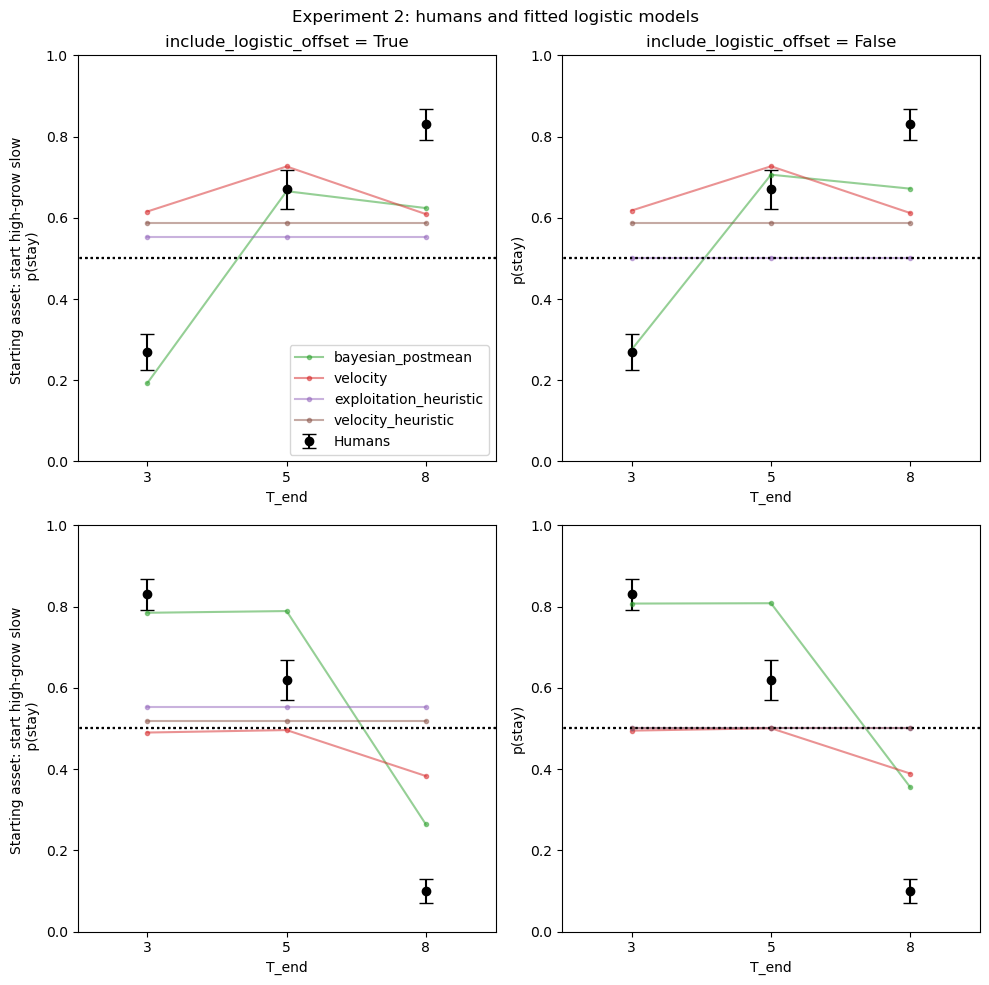

In [12]:
# Experiment 2B logistic choice probs
num_tasks = n_questions
beta = 5
T_ends_complete = [range(3,11)]
t_nows_complete = 2*np.ones((len(T_ends_complete))).astype(int)
logistic_probs_stay = np.zeros((2, len(models)*2, len(T_ends)))
logistic_probs_stay_bytesttrajidx = np.zeros((2, len(models)*2, Trajs[agent_names[0]].shape[1], len(T_ends)))
fig,ax = plt.subplots(2,2, figsize=(10,10))

subplot_count = -1
for include_offset_param_val in [True,False]:
    subplot_count = subplot_count+1;
    
    # Load data
    if(include_offset_param_val):
        suffix_offset = "_offset"
    else:
        suffix_offset = "_nooffset"
    filename = dataset_name+"_fits_logistic_heuristics"+suffix_offset
    with open(os.path.join(fitspath,filename+'.pickle'), 'rb') as handle:
        b = pickle.load(handle)
    best_params_fitted = b["best_params_fitted"]
    crossentropy_fitted = b["crossentropy_fitted"]
    data = b["data"]
    models = b["models"]
    include_offset_param = b["include_offset_param"]

    # Visualize fits
    for forced_agent in range(2):
        ax[forced_agent,subplot_count].errorbar(range(num_tasks),choices_mean[forced_agent,:], yerr=choices_sem[forced_agent,:], fmt='-o',color="k", linestyle="", capsize=5, label="Humans")
        for model_idx in range(len(models)):           
            start_agent = start_agents[forced_agent]
            for testtraj_idx in range(num_testtrajs):
                rs_traj = Trajs[start_agent][:,testtraj_idx]
                for task in range(len(T_ends)):
                    t_now = t_nows[task]
                    T_end = T_ends[task]
                    logistic_probs_stay_bytesttrajidx[forced_agent, model_idx, testtraj_idx, task] = prob_stay_logistic(theta=best_params_fitted[model_idx,:], T_end=T_end, t_now=t_now, start_agent=start_agent, model=models[model_idx], rs_traj=rs_traj, include_offset_param=include_offset_param)
            # Average over the different test trajectories, where weights are determined by the proportion of participants that got each test trajectory.
            logistic_probs_stay[forced_agent, model_idx, :] = np.sum(logistic_probs_stay_bytesttrajidx[forced_agent, model_idx, :, :] * (num_subjss[forced_agent,:,0:1]/np.sum(num_subjss[forced_agent,:,0:1])), axis=0)

            
            ax[forced_agent,subplot_count].plot(range(num_tasks), logistic_probs_stay[forced_agent, model_idx,:], ".-", color="C"+str(model_idx+2), alpha=0.5, label=models[model_idx])
            ax[forced_agent,subplot_count].plot([-1,3],[0.5,0.5], "k:")
            if(agent_names[forced_agent]=="Velocity"):
                ax[forced_agent,0].set_ylabel("Starting asset: start low-grow fast \n p(stay)")
            else:
                ax[forced_agent,0].set_ylabel("Starting asset: start high-grow slow \n p(stay)")
            ax[forced_agent,1].set_ylabel("p(stay)")
            ax[forced_agent,subplot_count].set_ylim([0,1])
            ax[forced_agent,subplot_count].set_xlim([-0.5,2.5])
            ax[forced_agent,subplot_count].set_xticks([0,1,2])
            ax[forced_agent,subplot_count].set_xticklabels([3,5,8])
            ax[forced_agent,subplot_count].set_xlabel("T_end")
            ax[0,subplot_count].set_title("include_logistic_offset = "+str(include_offset_param))

        ax[0,0].legend()
fig.suptitle("Experiment 2: humans and fitted logistic models")
fig.tight_layout()
#plt.savefig(os.path.join(figpath,dataset_name+"_stayswitch_modelfits_logistic_heuristics"), dpi=300)
plt.show()

## Model comparison: CV

In [15]:
# CV done separately for each task condition. This ensures that we always have 2*3=6 p(stay) values, one for each question, to fit the model to.

import numpy as np
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5

# Initialize KFold
seed = 1
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)


prob_stay_folds_train = np.zeros((k_folds,2,n_questions))
n_stay_folds_train_nsubjs = np.zeros((k_folds,2,n_questions))
prob_stay_folds_test = np.zeros((k_folds,2,n_questions))
n_stay_folds_test_nsubjs = np.zeros((k_folds,2,n_questions))


num_stay_folds_train = np.zeros((k_folds,2,3,n_questions))
num_stay_folds_train_nsubjs = np.zeros((k_folds,2,3,n_questions))
num_stay_folds_test = np.zeros((k_folds,2,3,n_questions))
num_stay_folds_test_nsubjs = np.zeros((k_folds,2,3,n_questions))

# Create train-test splits for each column/question independently
for cond_idx in range(2):
    choices = choices_allconds[agent_names[cond_idx]]
    testtrajidx_cond = testtrajidx_allconds[agent_names[cond_idx]]
    testtrajidx_cond = np.tile(testtrajidx_cond[:,None],n_questions) # Expand a second dimension for n_questions.
    n_subj = choices.shape[0]
    col_data = range(choices.shape[0]*choices.shape[1])
    fold_idx=-1
    for train_idx, test_idx in kf.split(col_data):
        fold_idx = fold_idx+1
        for question in range(n_questions):
            relevant_train_idx = np.where((train_idx>=(question)*n_subj) * (train_idx<(question+1)*n_subj)==1)[0]
            relevant_test_idx = np.where((test_idx>=(question)*n_subj) * (test_idx<(question+1)*n_subj)==1)[0]
            relevant_subjs_train = train_idx[relevant_train_idx]-(question)*n_subj
            relevant_subjs_test = test_idx[relevant_test_idx]-(question)*n_subj
            
            relevant_choices_train = choices[relevant_subjs_train,question]
            relevant_choices_test = choices[relevant_subjs_test,question]
            relevant_testtrajidx_train = testtrajidx_cond[relevant_subjs_train,question]
            relevant_testtrajidx_test = testtrajidx_cond[relevant_subjs_test,question]
            
            for testtraj_idx in range(Trajs[agent_names[0]].shape[1]):
                relevant_testtraj_questions_idx_train = np.where(relevant_testtrajidx_train==testtraj_idx)[0]
                relevant_testtraj_questions_idx_test = np.where(relevant_testtrajidx_test==testtraj_idx)[0]
                num_stay_folds_train_nsubjs[fold_idx, cond_idx, testtraj_idx, question] = len(relevant_testtraj_questions_idx_train)
                num_stay_folds_test_nsubjs[fold_idx, cond_idx, testtraj_idx, question] = len(relevant_testtraj_questions_idx_test)
                num_stay_folds_train[fold_idx, cond_idx, testtraj_idx, question] = np.sum(relevant_choices_train[relevant_testtraj_questions_idx_train])
                num_stay_folds_test[fold_idx, cond_idx, testtraj_idx, question] = np.sum(relevant_choices_test[relevant_testtraj_questions_idx_test])
                
# print(prob_stay_folds_train)
print(num_stay_folds_train_nsubjs[:,0,:,:])
print()
print(num_stay_folds_test[:,0,:,:]/num_stay_folds_test_nsubjs[:,0,:,:])


[[[29. 29. 29.]
  [19. 24. 22.]
  [33. 27. 28.]]

 [[30. 28. 28.]
  [23. 21. 23.]
  [26. 29. 32.]]

 [[29. 33. 31.]
  [19. 21. 21.]
  [34. 26. 26.]]

 [[31. 31. 31.]
  [24. 20. 18.]
  [24. 30. 31.]]

 [[33. 31. 33.]
  [19. 18. 20.]
  [27. 32. 27.]]]

[[[0.33333333 0.88888889 0.88888889]
  [0.28571429 0.5        1.        ]
  [0.33333333 0.55555556 0.75      ]]

 [[0.25       0.8        0.8       ]
  [0.         1.         1.        ]
  [0.3        0.28571429 0.5       ]]

 [[0.33333333 0.6        0.85714286]
  [0.57142857 0.8        1.        ]
  [0.         0.5        0.7       ]]

 [[0.         0.57142857 0.85714286]
  [0.5        0.83333333 0.875     ]
  [0.5        0.83333333 0.4       ]]

 [[0.         0.71428571 1.        ]
  [0.14285714 0.625      1.        ]
  [0.11111111 0.5        0.88888889]]]


In [16]:
# CV fit on training folds.
# T_ends = [3,5,8]
# t_nows = [2,2,2]
start_agents=["velocity","exploitation"]
models = ["bayesian_postmean","velocity","exploitation_heuristic","velocity_heuristic"]
n_inits = 10


params_init = np.zeros((len(models)*2,k_folds, n_inits, 3))
params_init[:] = np.nan
params_fitted = np.zeros((len(models)*2, k_folds,n_inits, 3))
params_fitted[:] = np.nan
crossentropy_fitted = np.zeros((len(models)*2,k_folds, n_inits))
    
model_count = -1
for include_offset_param in [True,False]:
    if(include_offset_param):
        lb = [1e-3, 1e-3, -10]
        ub = [1.5, 50, 10]
        suffix_offset = "_offset"
    else:
        lb = [1e-3, 1e-3]
        ub = [1.5, 50]
        suffix_offset = "_nooffset"

    constraint = scipy.optimize.Bounds(lb=lb, ub=ub)

    for model_idx in range(len(models)):
        model_count = model_count+1;
        model = models[model_idx]
        for fold_idx in range(k_folds):
            print(model, include_offset_param,fold_idx)
            n_subjs_fold = num_stay_folds_train_nsubjs[fold_idx,:,:,:]
            n_stay_fold = num_stay_folds_train[fold_idx,:,:,:]
            for rand_init_idx in range(n_inits):
                print(rand_init_idx)
                params_init[model_count, fold_idx, rand_init_idx,0:len(lb)] = np.random.uniform(low=lb, high=ub)
                res = scipy.optimize.minimize(crossentropy_loss, np.squeeze(params_init[model_count,fold_idx, rand_init_idx,0:len(lb)]), bounds=constraint, 
                                          args = (T_ends, t_nows, start_agents, model, n_stay_fold, n_subjs_fold, include_offset_param), method='L-BFGS-B', options={'disp': True})
                params_fitted[model_count,fold_idx,rand_init_idx,0:len(lb)] = res.x
                crossentropy_fitted[model_count,fold_idx,rand_init_idx] = res.fun
            


bayesian_postmean True 0
0


C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\2668785260.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)


1
2
3
4
5
6
7
8
9
bayesian_postmean True 1
0
1
2
3
4
5
6
7
8
9
bayesian_postmean True 2
0
1
2
3
4
5
6
7
8
9
bayesian_postmean True 3
0
1
2
3
4
5
6
7
8
9
bayesian_postmean True 4
0
1
2
3
4
5
6
7
8
9
velocity True 0
0
1
2
3
4
5
6
7
8
9
velocity True 1
0
1
2
3
4
5
6
7
8
9
velocity True 2
0
1
2
3
4
5
6
7
8
9
velocity True 3
0
1
2
3
4
5
6
7
8
9
velocity True 4
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 0
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 1
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 2
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 3
0
1
2
3
4
5
6
7
8
9
exploitation_heuristic True 4
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 0
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 1
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 2
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 3
0
1
2
3
4
5
6
7
8
9
velocity_heuristic True 4
0
1
2
3
4
5
6
7
8
9
bayesian_postmean False 0
0
1
2
3
4
5
6
7
8
9
bayesian_postmean False 1
0
1
2
3
4
5
6
7
8
9
bayesian_postmean False 2
0
1
2
3
4
5
6
7
8
9
baye

In [17]:
# Compute test loss on left-out folds.
best_params_fitted = np.zeros((len(models)*2, k_folds,3))
crossentropy_testloss = np.zeros((len(models)*2, k_folds))
best_params_fitted[:] = np.nan
model_count = -1
for include_offset_param in [True,False]:
    for model_idx in range(len(models)):
        model_count = model_count+1;
        model = models[model_idx]
        for fold_idx in range(k_folds):
            print(model, include_offset_param,fold_idx)
            n_subj_fold = num_stay_folds_test_nsubjs[fold_idx,:,:,:]
            n_stay_fold = num_stay_folds_test[fold_idx,:,:,:]
            bestfit_idx_bymodel = np.argmin(crossentropy_fitted[model_count,fold_idx,:])
            best_params_fitted[model_count,fold_idx,:] = params_fitted[model_count,fold_idx,bestfit_idx_bymodel,:]
            crossentropy_testloss[model_count, fold_idx] = crossentropy_loss(theta=best_params_fitted[model_count,fold_idx,:], T_ends=T_ends, t_nows=t_nows, start_agents=start_agents, model=model, num_choosestays=n_stay_fold, num_subjss=n_subj_fold, include_offset_param=include_offset_param)


import pickle
filename = dataset_name+"_fits_logistic_heuristics_cv"
a = {"k_folds":k_folds, "crossentropy_testloss":crossentropy_testloss, "num_stay_folds_train":num_stay_folds_train, "num_stay_folds_test":num_stay_folds_test, "num_stay_folds_train_nsubjs":num_stay_folds_train_nsubjs,"num_stay_folds_test_nsubjs":num_stay_folds_test_nsubjs, 'params_init':params_init,'params_fitted':params_fitted, 'best_params_fitted':best_params_fitted, 'crossentropy_fitted':crossentropy_fitted, 'models':models, 'include_offset_param':[True,False], 'mturk_IDs': [], 'data_dims': ["subject","question (T_end = 3,5,8 in this order)"], 'data': choices, "cv_seed":seed}
with open(os.path.join(fitspath,filename+'.pickle'), 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

bayesian_postmean True 0
bayesian_postmean True 1
bayesian_postmean True 2
bayesian_postmean True 3
bayesian_postmean True 4
velocity True 0
velocity True 1
velocity True 2
velocity True 3
velocity True 4
exploitation_heuristic True 0
exploitation_heuristic True 1
exploitation_heuristic True 2
exploitation_heuristic True 3
exploitation_heuristic True 4
velocity_heuristic True 0
velocity_heuristic True 1
velocity_heuristic True 2
velocity_heuristic True 3
velocity_heuristic True 4
bayesian_postmean False 0
bayesian_postmean False 1


C:\Users\liu_s\AppData\Local\Temp\ipykernel_42840\2668785260.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_p_thetaj_given_rj[theta_val_idx] += log_normpdf(rho_t_given_thetaj, r_t0_traj, nu)


bayesian_postmean False 2
bayesian_postmean False 3
bayesian_postmean False 4
velocity False 0
velocity False 1
velocity False 2
velocity False 3
velocity False 4
exploitation_heuristic False 0
exploitation_heuristic False 1
exploitation_heuristic False 2
exploitation_heuristic False 3
exploitation_heuristic False 4
velocity_heuristic False 0
velocity_heuristic False 1
velocity_heuristic False 2
velocity_heuristic False 3
velocity_heuristic False 4


[68.53898053 79.58207941 82.55841172 82.5418879  69.38182535 79.49390984
 83.17944556 82.32416251]
[0.         3.4314788  2.98784792 3.21378858 0.40262641 3.48356417
 2.99409023 3.27059841]



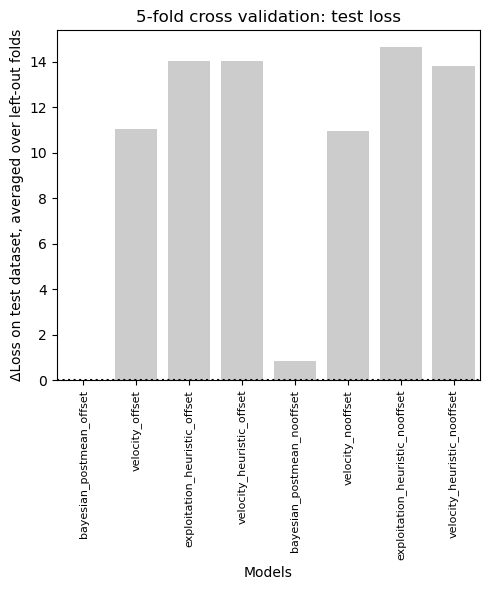

In [18]:
model_fullnames = ["bayesian_postmean_offset","velocity_offset", "exploitation_heuristic_offset","velocity_heuristic_offset","bayesian_postmean_nooffset","velocity_nooffset", "exploitation_heuristic_nooffset","velocity_heuristic_nooffset"]

# 2) Average over folds for each subject, then sum over subjects.
crossentropy_cv = np.mean(crossentropy_testloss,axis=1)
print(crossentropy_cv)
crossentropy_cv_sem = np.nanstd(crossentropy_testloss-np.min(crossentropy_testloss,axis=0)[None,:], ddof=1, axis=1) / np.sqrt(k_folds) # Errorbars are SEM over 
print(crossentropy_cv_sem)
print()

# 3) Visualize
fig, ax = plt.subplots(1,1,figsize=(5,6))
ax.bar(range(len(model_fullnames)), crossentropy_cv-np.min(crossentropy_cv), color="k", alpha=0.2)
yerr = crossentropy_cv_sem
ax.plot([-0.5,len(model_fullnames)-1+0.5],[0,0],"k:")
ax.set_xlim([-0.5,len(model_fullnames)-1+0.5])
ax.set_ylabel("ΔLoss on test dataset, averaged over left-out folds")
ax.set_xlabel("Models")
ax.set_xticks(range(len(model_fullnames)))
ax.set_xticklabels(model_fullnames, fontsize=8)
ax.tick_params(axis='x', labelrotation=90) 
ax.set_title(str(k_folds)+"-fold cross validation: test loss")
fig.tight_layout()
# plt.savefig(os.path.join(figpath,dataset_name+"_"+str(k_folds)+"foldcv_testloss"), dpi=300)
plt.show()